If running in a new environment, such as Google Colab, run this first.

In [195]:
import subprocess
import sys

# !git clone https://github.com/zach401/acnportal.git
# !pip install acnportal/.
subprocess.check_call([sys.executable, "-m", "pip", "install", "git+https://github.com/caltech-netlab/adacharge"])
import adacharge


# ACN-Sim: Testing
## Implementing a Custom Algorithm
### by Omar Al-Shafe'i
#### Last updated: 06/12/2023

In this lesson we will learn how to develop a custom algorithm and run it using ACN-Sim. For this example we will be writing an Earliest Deadline First Algorithm. This algorithm is already available as part of the SortingAlgorithm in the algorithms package, so we will compare the results of our implementation with the included one.

## Custom Algorithm

All custom algorithms should inherit from the abstract class BaseAlgorithm. It is the responsibility of all derived classes to implement the schedule method. This method takes as an input a list of EVs which are currently connected to the system but have not yet finished charging. Its output is a dictionary which maps a station_id to a list of charging rates. Each charging rate is valid for one period measured relative to the current period.

For Example: 
 * schedule[‘abc’][0] is the charging rate for station ‘abc’ during the current period 
 * schedule[‘abc’][1] is the charging rate for the next period 
 * and so on. 
 
If an algorithm only produces charging rates for the current time period, the length of each list should be 1. If this is the case, make sure to also set the maximum resolve period to be 1 period so that the algorithm will be called each period. An alternative is to repeat the charging rate a number of times equal to the max recompute period.

As mentioned previously our new algorithm should inherit from BaseAlgorithm or a subclass of it.

#### def __init__(self, increment=1):

We can override the __init__() method if we need to pass additional configuration information to the algorithm. In this case we pass in the increment which will be used when searching for a feasible rate.

#### schedule(self, active_evs)

We next need to override the schedule() method. The signature of this method should remain the same, as it is called internally in Simulator. If an algorithm needs additional parameters consider passing them through the constructor.

In [196]:
from acnportal.algorithms import BaseAlgorithm
import math
class EarliestDeadlineFirstAlgo(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda x: x.estimated_departure)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

In [ ]:
import math
class SmoothedLeastLaxityFirst(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        # update set of active EVs: Vt
        # calculate laxity for each ev i in Vt
        laxities = []
        for ev in active_evs:
            if ev.estimated_departure - self.interface.current_time < 0:
                return ValueError('schedule->active_evs doesnt contain only active EVs')
            laxities.append((ev.estimated_departure - self.interface.current_time)
                            - ev.)
            
        # schedule = {ev.station_id: [0] for ev in active_evs}
        # # Next, we sort the active_evs by their estimated departure time.
        # sorted_evs = sorted(active_evs, key=lambda x: x.estimated_departure)
        # 
        # # We now iterate over the sorted list of EVs.
        # for ev in sorted_evs:
        #     # First try to charge the EV at its maximum rate. Remember that each schedule value
        #     #   must be a list, even if it only has one element.
        #     schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]
        # 
        #     # If this is not feasible, we will reduce the rate.
        #     #   interface.is_feasible() is one way to interact with the constraint set
        #     #   of the network. We will explore another more direct method in lesson 3.
        #     while not self.interface.is_feasible(schedule, 0):
        # 
        #         # Since the maximum rate was not feasible, we should try a lower rate.
        #         schedule[ev.station_id][0] -= self._increment
        # 
        #         # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
        #         if schedule[ev.station_id][0] < 0:
        #             schedule[ev.station_id] = [0]
        #             break
        return {ev.station_id: [0] for ev in active_evs}
        # return schedule

In [197]:
class PriorityEarliestDeadlineFirstAlgo(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = 0.1
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda x: x.estimated_departure)

        i =  1
        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [int(self.interface.max_pilot_signal(ev.station_id)/(i))]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            i += 1
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

Note the structure of the schedule dict which is returned should be something like:

```
{
    'CA-301': [32, 32, 32, 16, 16, ..., 8],
    'CA-302': [8, 13, 13, 15, 6, ..., 0],
    ...,
    'CA-408': [24, 24, 24, 24, 0, ..., 0]
}
```
For the special case when an algorithm only calculates a target rate for the next time interval instead of an entire schedule of rates, the structure should be:

```
{
    'CA-301': [32],
    'CA-302': [8],
    ...,
    'CA-408': [24]
}
```

Note that these are single element lists and NOT floats or integers.

In [198]:
class LeastLaxityFirstAlg(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1
    def laxity(self, ev) -> float:
        """ Calculate laxity of the EV.

        Args:
            ev (EV): An EV object.

        Returns:
            float: The laxity of the EV.
        """
        lax = (ev.estimated_departure - self.interface.current_time) - (
            self.interface.remaining_amp_periods(ev) / self.interface.max_pilot_signal(ev.station_id)
        )
        return lax

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda ev: self.laxity(ev))

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

In [199]:
from acnportal.algorithms import BaseAlgorithm, UpperBoundEstimatorBase, infrastructure_constraints_feasible,format_array_schedule
from acnportal.algorithms import (
     enforce_pilot_limit,
     apply_upper_bound_estimate,
     apply_minimum_charging_rate,
     remove_finished_sessions,
 )
import numpy as np

# from upper_bound_estimator import UpperBoundEstimatorBase
# from base_algorithm import BaseAlgorithm
# from utils import infrastructure_constraints_feasible
# from postprocessing import format_array_schedule
# from preprocessing import (
#     enforce_pilot_limit,
#     apply_upper_bound_estimate,
#     apply_minimum_charging_rate,
#     remove_finished_sessions,
# )
from warnings import warn

from acnportal.acnsim.interface import SessionInfo, InfrastructureInfo, Interface

class LeastLaxityFirstGrouped(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    laxities from smallest to highest.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by laxities. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1, tolerance=0.1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1
        self.amount_to_maximum_rate = 10
        self.tolerance = tolerance
    def laxity(self,ev: SessionInfo) -> float:
        """ Calculate laxity of the EV.

        Args:
            ev (EV): An EV object.

        Returns:
            float: The laxity of the EV.
        """
        lax = (ev.estimated_departure - self.interface.current_time) - (
            self.interface.remaining_amp_periods(ev) / self.interface.max_pilot_signal(ev.station_id)
        )
        return lax
    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}

        # # sorted_evs = sorted(active_evs, key=(ev.estimated_departure - iface.current_time) - (
        #     iface.remaining_amp_periods(ev) / iface.max_pilot_signal(ev.station_id)
        # ))
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda ev: self.laxity(ev))
        ev_groups = [[] for i in range(len(sorted_evs))]
        index = -1
        for ev1_ind in range(len(sorted_evs)):
            index += 1
            for ev2_ind in range(ev1_ind + 1, len(sorted_evs)):
                first_ev, second_ev = sorted_evs[ev1_ind], sorted_evs[ev2_ind]
                if abs(self.laxity(first_ev) - self.laxity(second_ev)) < self.tolerance:
                    ev_groups[index].extend([first_ev, second_ev])
        for group in ev_groups:
            for ev in group:
                schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]
            
            while not self.interface.is_feasible(schedule, 0):
                for ev in group:
                    # Since the maximum rate was not feasible, we should try a lower rate.
                    schedule[ev.station_id][0] -= self._increment

                    # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                    if schedule[ev.station_id][0] < 0:
                        schedule[ev.station_id] = [0]
                if group.count(0) == len(group):
                    break
        return schedule
                    
                
                
            
            
        
        # # We now iterate over the sorted list of EVs.
        # for ev in sorted_evs:
        #     # First try to charge the EV at its maximum rate. Remember that each schedule value
        #     #   must be a list, even if it only has one element.
        #     schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

        #     # If this is not feasible, we will reduce the rate.
        #     #   interface.is_feasible() is one way to interact with the constraint set
        #     #   of the network. We will explore another more direct method in lesson 3.
        #     while not self.interface.is_feasible(schedule, 0):

        #         # Since the maximum rate was not feasible, we should try a lower rate.
        #         schedule[ev.station_id][0] -= self._increment

        #         # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
        #         if schedule[ev.station_id][0] < 0:
        #             schedule[ev.station_id] = [0]
        #             break
        # return schedule
        



In [200]:
from acnportal.algorithms import BaseAlgorithm
import math
class FirstComeFirstServed(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda ev: ev.arrival)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

In [201]:
class LastComeFirstServed(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda ev: ev.arrival, reverse=True)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

In [202]:
from acnportal.algorithms import BaseAlgorithm
import math
class ShortestJobNextAlg(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda x: (x.estimated_departure - self.interface.current_time))

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

In [203]:
from acnportal.algorithms import BaseAlgorithm
import math
class LongestRemainingTimeAlg(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1
    

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}
        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda x: (x.estimated_departure - self.interface.current_time),reverse=True)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

In [204]:
from collections import deque

class RoundRobin(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1
    

    def schedule(self, active_evs):

        '''
        Round Robin (RR) is a simple algorithm
that attempts to equally share charging capacity among all
active EVs. It creates a queue of all active EVs. For each
EV in the queue, it checks if it is feasible to increment its
charging rate by one unit. If it is, it increments the rate
and replaces the EV at the end of the queue. If it is not,
the charging rate of the EV is fixed, and the algorithm
does not return the EV to the queue. This continues until
the queue of EVs is empty

        '''
        
        schedule = {ev.station_id: [0] for ev in active_evs}

        rate_idx = np.zeros(infrastructure.num_stations, dtype=int)
        allowable_pilots = infrastructure.allowable_pilots.copy()
        # Create a queue to manage the order of charging
        charging_queue = deque(active_evs)

        while len(queue) > 0:
            session = charging_queue.popleft()
            i = infrastructure.get_station_index(session.station_id)
            if rate_idx[i] < len(allowable_pilots[i]) - 1:
                schedule[i] = allowable_pilots[i][rate_idx[i] + 1]
                if infrastructure_constraints_feasible(schedule, infrastructure):
                    rate_idx[i] += 1
                    queue.append(session)
                else:
                    schedule[i] = allowable_pilots[i][rate_idx[i]]
        return schedule

        
        # Iterate over the sorted list of EVs
        # for ev in charging_queue:
        #     # First try to charge the EV at its maximum rate. Remember that each schedule value
        #     #   must be a list, even if it only has one element.
        #     schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]
    
        #     # If this is not feasible, we will reduce the rate.
        #     #   interface.is_feasible() is one way to interact with the constraint set
        #     #   of the network. We will explore another more direct method in lesson 3.
        #     while not self.interface.is_feasible(schedule, 0):
    
        #         # Since the maximum rate was not feasible, we should try a lower rate.
        #         schedule[ev.station_id][0] -= self._increment
    
        #         # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
        #         if schedule[ev.station_id][0] < 0:
        #             schedule[ev.station_id] = [0]
        #             break
    
        #     # Append the EV back to the end of the queue for the next round
        #     charging_queue.append(ev)
    
        # return schedule

In [205]:
from acnportal.contrib.acnsim import StochasticNetwork
def level_1_network(transformer_cap=200, evse_per_phase=34):
    """ Configurable charging network for level-1 EVSEs connected line to ground
        at 120 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    voltage = 120

    # Define the sets of EVSEs in the Caltech ACN.
    A_ids = ['A-{0}'.format(i) for i in range(evse_per_phase)]
    B_ids = ['B-{0}'.format(i) for i in range(evse_per_phase)]
    C_ids = ['C-{0}'.format(i) for i in range(evse_per_phase)]

    # Add Caltech EVSEs
    for evse_id in A_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, 0)
    for evse_id in B_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, 120)
    for evse_id in C_ids:
        network.register_evse(acnsim.FiniteRatesEVSE(evse_id, [0, 16]), voltage, -120)

    # Add Caltech Constraint Set
    I3a = acnsim.Current(A_ids)
    I3b = acnsim.Current(B_ids)
    I3c = acnsim.Current(C_ids)

    # Define intermediate currents
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 277
    secondary_side_constr = transformer_cap * 1000 / 3 / 120
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network


def level_2_network(transformer_cap=200, evse_per_phase=34):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 208 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    voltage = 208
    evse_type = 'AeroVironment'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(evse_per_phase)]
    BC_ids = ['BC-{0}'.format(i) for i in range(evse_per_phase)]
    CA_ids = ['CA-{0}'.format(i) for i in range(evse_per_phase)]

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 277
    secondary_side_constr = transformer_cap * 1000 / 3 / 120
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

## Running the Algorithm

Now that we have implemented our algorithm, we can try it out using the same experiment setup as in lesson 1. The only difference will be which scheduling algorithm we use. For fun, lets compare our algorithm against to included implementation of the earliest deadline first algorithm.

In [206]:
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from copy import deepcopy

from acnportal import algorithms
from acnportal import acnsim

from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
# -- Experiment Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = timezone.localize(datetime(2018, 9, 5))
end = timezone.localize(datetime(2018, 9, 10))
# How long each time discrete time interval in the simulation should be.
period = 5  # minutes

# Voltage of the network.
voltage = 208  # volts

# Default maximum charging rate for each EV battery.
default_battery_power = 6.6 # kW
site = 'caltech'
signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}


# -- Network -----------------------------------------------------------------------------------------------------------
# cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage)
cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage)
# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = 'DEMO_TOKEN'
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)


# -- Scheduling Algorithm ----------------------------------------------------------------------------------------------
scheduling_algorithms = []
labels_arr = []

# sch_their_uncontrolled = EarliestDeadlineFirstAlgo(increment=1)
# scheduling_algorithms.append(sch_their_uncontrolled)
# labels_arr.append('Our EDF')

sch_our_edf = EarliestDeadlineFirstAlgo(increment=1)
scheduling_algorithms.append(sch_our_edf)
labels_arr.append('Our EDF')


sch_our_llf = LeastLaxityFirstAlg(increment=1)
scheduling_algorithms.append(sch_our_llf)
labels_arr.append('Our LLF')

sch_their_llf = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
scheduling_algorithms.append(sch_their_llf)
labels_arr.append('Their LLF')


# sch_our_ellf = EnhancedLeastLaxityFirst(increment=1)
# scheduling_algorithms.append(sch_our_ellf)
# labels_arr.append('Our ELLF')

# # sch_our_LLFG = LeastLaxityFirstGrouped(increment=1,tolerance=30)
# # scheduling_algorithms.append(sch_our_LLFG)
# # labels_arr.append('Our LLFG')


sch_our_SJN = ShortestJobNextAlg(increment=1)
scheduling_algorithms.append(sch_our_SJN)
labels_arr.append('Our SJN')

sch_our_LRT = LongestRemainingTimeAlg(increment=1)
scheduling_algorithms.append(sch_our_LRT)
labels_arr.append('Our LRT')

# sch_our_PEDF = PriorityEarliestDeadlineFirstAlgo(increment=1)
# scheduling_algorithms.append(sch_our_PEDF)
# labels_arr.append('Our PEDF')

# sch_our_RR = RoundRobin(increment=1)
# scheduling_algorithms.append(sch_our_RR)
# labels_arr.append('Our RR')




In [207]:
import warnings
def run_experiment(network, algorithm, events):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """

    timezone = pytz.timezone('America/Los_Angeles')
    start = timezone.localize(datetime(2018, 9, 5))
    end = timezone.localize(datetime(2018, 9, 10))
    period = 5  # minute


    sch = deepcopy(algorithm)
    cn = deepcopy(network)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = acnsim.Simulator(cn, sch, events, start,period=period, verbose=False, signals=signals)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    sim.run()

    r = {'proportion_of_energy_delivered': acnsim.proportion_of_energy_delivered(sim),
         'energy_delivered': sum(ev.energy_delivered for ev in sim.ev_history.values()),
         'num_swaps': cn.swaps,
         'num_never_charged': cn.never_charged,
         'energy_cost': acnsim.energy_cost(sim),
         'demand_charge': acnsim.demand_charge(sim)
         }
    r['total_cost'] = r['energy_cost'] + r['demand_charge']
    r['$/kWh'] = r['total_cost'] / r['energy_delivered']
    return r

In [208]:
# cn_lvl2_200kw_30 = level_2_network(transformer_cap=200, evse_per_phase=10)
all_simulations = []

for scheduling in scheduling_algorithms:
    simulation = acnsim.Simulator(deepcopy(cn), scheduling, deepcopy(events), start,signals=signals, period=period, verbose=False)
    simulation.run()
    all_simulations.append(simulation)

In [209]:
# # -- Simulator ---------------------------------------------------------------------------------------------------------
# uncontrolled = algorithms.UncontrolledCharging()

# sim = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), uncontrolled, deepcopy(events), start,signals=signals, period=period, verbose=False)
# sim.run()
# all_simulations.append(sim)
# labels_arr.append('Uncontrolled')

In [210]:
# For comparison we will also run the builtin earliest deadline first algorithm
# sim2 = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), sch2, deepcopy(events), start, signals=signals, period=period, verbose=False)
# sim2.run()
# all_simulations.append(sim2)
# labels_arr.append('Their LLF')

In [211]:
# sim3 = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), sch3, deepcopy(events), start, signals=signals, period=period, verbose=False)
# sim3.run()
# all_simulations.append(sim3)
# labels_arr.append('Uncontrolled')



In [212]:
# simSJN = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), schSJN, deepcopy(events), start, signals=signals, period=period, verbose=False)
# simSJN.run()
# all_simulations.append(simSJN)

In [213]:
# simLRT = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), schLRT, deepcopy(events), start, signals=signals, period=period, verbose=False)
# simLRT.run()
# all_simulations.append(simLRT)

In [214]:
# simPEDF = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), schPEDF, deepcopy(events), start, signals=signals, period=period, verbose=False)
# simPEDF.run()
# all_simulations.append(simPEDF)

In [215]:
# quick_charge_obj = [adacharge.ObjectiveComponent(adacharge.quick_charge)]
# mpc = adacharge.AdaptiveSchedulingAlgorithm(quick_charge_obj, solver="ECOS")
# sim4 = acnsim.Simulator(deepcopy(cn_lvl2_200kw_30), mpc, deepcopy(events), start, signals=signals, period=period, verbose=False)

# res = run_experiment(deepcopy(cn_lvl2_200kw_30), mpc, deepcopy(events))
# print(acnsim.aggregate_current(res))

## Results

We can now compare the two algorithms side by side by looking that the plots of aggregated current. We see from these plots that our implementation matches th included one quite well. If we look closely however, we might see a small difference. This is because the included algorithm uses a more efficient bisection based method instead of our simpler linear search to find a feasible rate.

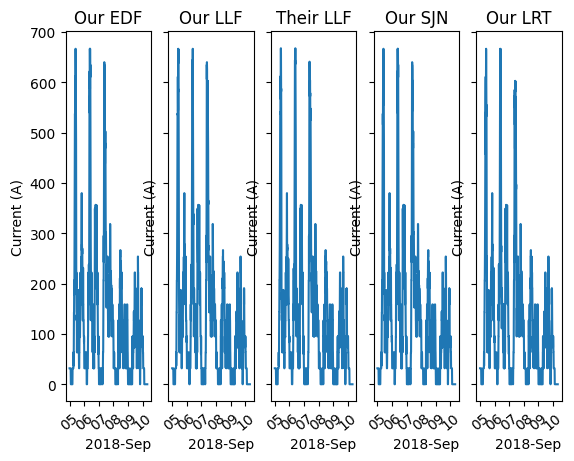

In [216]:


# Get list of datetimes over which the simulations were run.

# Set locator and formatter for datetimes on x-axis.
locator = mdates.AutoDateLocator(maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)


fig, axs = plt.subplots(1, len(all_simulations), sharey=True, sharex=True)
for i in range(len(all_simulations)):
    simulation = all_simulations[i]
    label = labels_arr[i]
    currents = acnsim.aggregate_current(simulation)
    dates = mdates.date2num(acnsim.datetimes_array(simulation))
    axs[i].plot(dates, currents, label=label)
    axs[i].set_title(label)
    
for ax in axs:
    ax.set_ylabel('Current (A)')
    for label in ax.get_xticklabels():
        label.set_rotation(40)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

plt.show()





In [217]:
import pandas as pd
import dataframe_image as dfi

# print(f'Proportion of energy delivered for sim: {total_energy_prop}')
# print(f'Proportion of energy delivered for sim: {total_energy_prop2}')
# print(f'Proportion of energy delivered for sim: {total_energy_prop3}')

# Data pro tabulku
data = {
    'Simulation name': [],
    'Proportion of energy delivered': [],
    'Energy cost':[],
    'Energy delivered':[],
}

for i, simulation in enumerate(all_simulations):
    label = labels_arr[i]
    data['Simulation name'].append(label)
    data['Proportion of energy delivered'].append( acnsim.proportion_of_energy_delivered(simulation))
    data['Energy cost'].append(acnsim.energy_cost(simulation))
    data['Energy delivered'].append(sum(ev.energy_delivered for ev in simulation.ev_history.values()))
    

# Vytvoření DataFrame
df = pd.DataFrame(data)





# Vytisknutí tabulky
df

# df2 = pd.DataFrame(data=d2)
# print(df2)


dfi.export(df,'experiment_comparison.png')




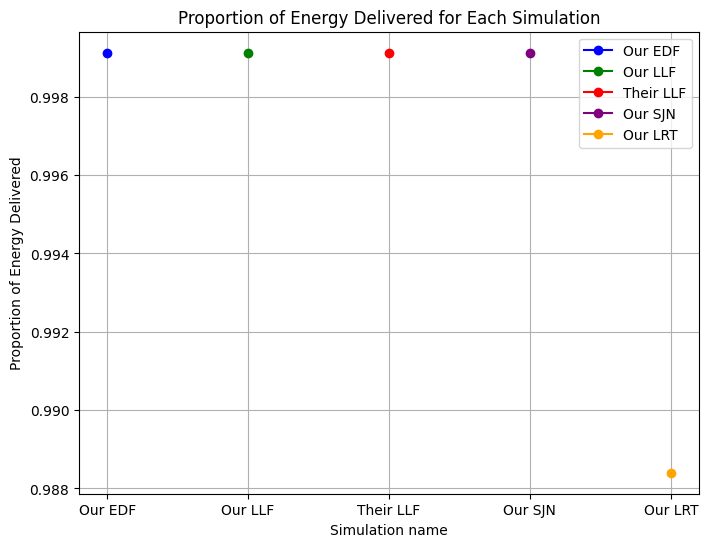

In [221]:
# Plotting the results
plt.figure(figsize=(8, 6))

# Define a list of colors for each simulation
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plotting multiple lines with different colors
for i in range(len(df)):
    plt.plot(df['Simulation name'][i], df['Proportion of energy delivered'][i], marker='o', color=colors[i], label=df['Simulation name'][i])

plt.title('Proportion of Energy Delivered for Each Simulation')
plt.xlabel('Simulation name')
plt.ylabel('Proportion of Energy Delivered')
plt.legend()
plt.grid(True)

plt.savefig('exp1.png')
plt.show()



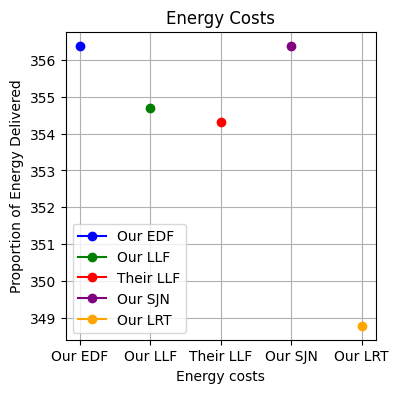

In [219]:
# Plotting the results
plt.figure(figsize=(4, 4))

# Define a list of colors for each simulation
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plotting multiple lines with different colors
for i in range(len(df)):
    plt.plot(df['Simulation name'][i], df['Energy cost'][i], marker='o', color=colors[i], label=df['Simulation name'][i])

plt.title('Energy Costs')
plt.xlabel('Energy costs')
plt.ylabel('Proportion of Energy Delivered')
plt.legend()
plt.grid(True)
plt.show()